# Perplexity Plots

Plots perplexities for larger range of languages.

In [1]:
# For importing utils
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from utils import PERTURBATIONS
from glob import glob

/nlp/scr/kallini/miniconda3/envs/mission-impossible-2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, model_type, checkpoints):
    
    results_path = 'perplexity_results_rev_test/{}_100M/{}_{}*_test_{}.csv'

    for file_data in file_info:
        model_perturb, model_test, marker, linestyle, legend_name = file_data
        all_files = glob(results_path.format(model_perturb, model_perturb, model_type, model_test))
        assert len(all_files) == 3, f"Expected 3 files, found {len(all_files)} for {model_perturb}"

        all_seeds_gmeans = []
        for file in all_files:
            df = pd.read_csv(file)
            gmeans = []

            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))

            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        ci = None
        if len(all_files) > 1:
            sems = stats.sem(all_seeds_gmeans, axis=0)
            # Calculate confidence interval using t-distribution
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(all_files)-1,
                                                loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        # Plotting
        ax.errorbar(checkpoints, means, ci, marker=marker, 
                    color=PERTURBATIONS[model_perturb]["color"],
                    linestyle=linestyle, label=legend_name)

    ax.set_title(title)
    if ax_i == 0:
        ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
    
    if title == "*Shuffle":
        ax.legend(fontsize=8, framealpha=1)
    else:
        ax.legend(fontsize=9, framealpha=1)
    ax.grid(True, color="lightgray")

In [4]:
def plot_perplexities_grouped(file_infos, titles, model_type, checkpoints):
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    
    axs_flat = axs.flatten()
    
    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, model_type, checkpoints)
        
    if model_type == "gpt2":
        model_type_title = "GPT-2 with Absolute Position Embeddings"
    elif model_type == "alibi":
        model_type_title = "GPT-2 with ALiBi"
    elif model_type == "rope":
        model_type_title = "GPT-2 with RoPE"
    plt.suptitle(f"Perplexities for {model_type_title}", fontsize=16)

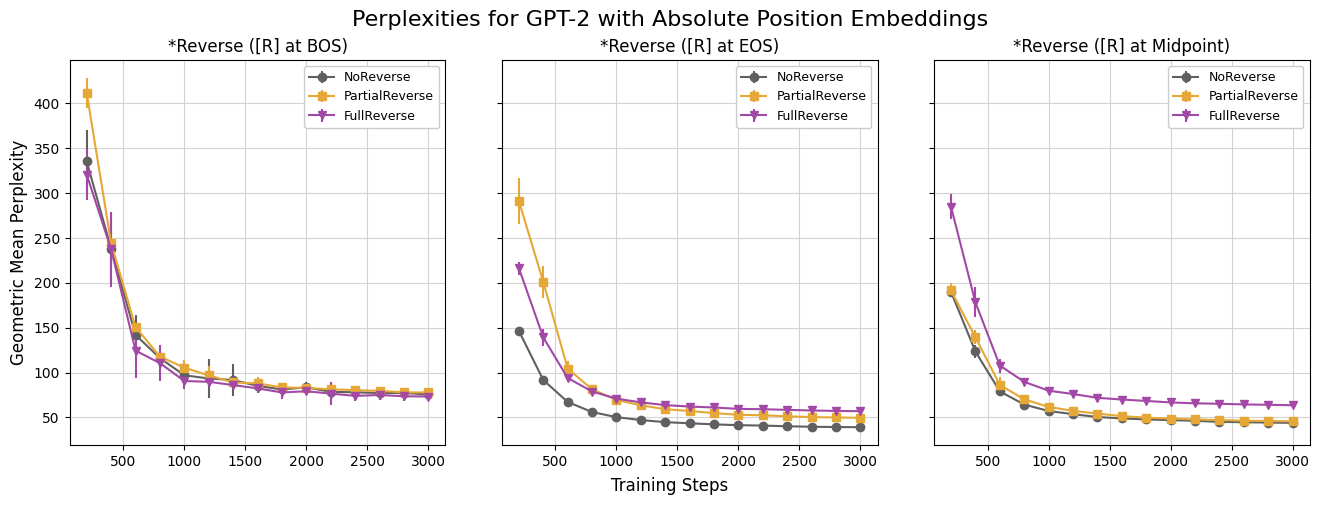

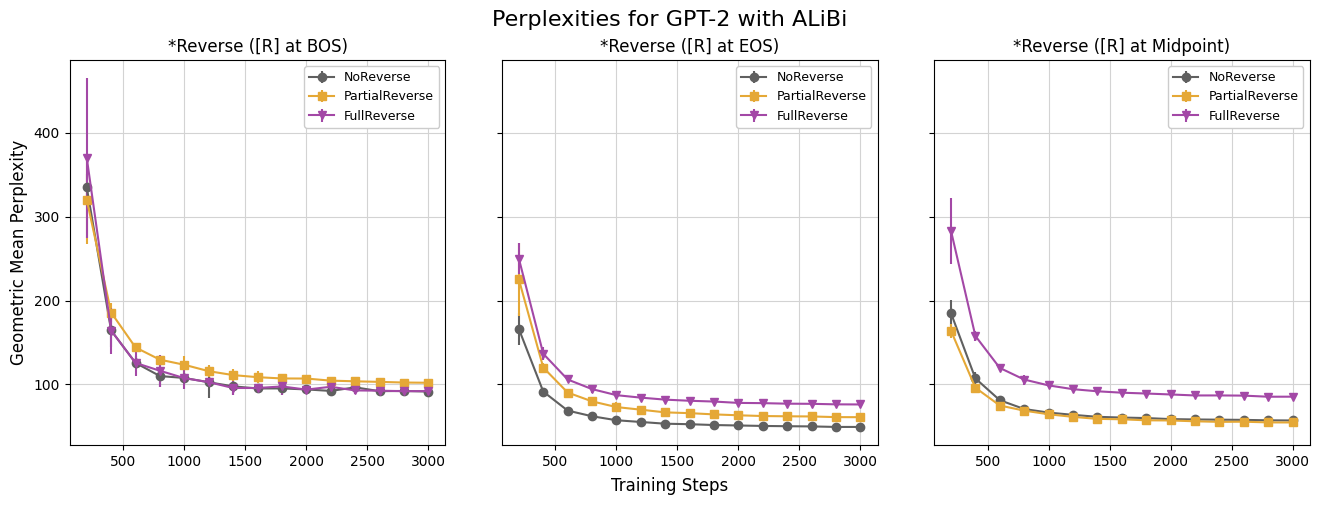

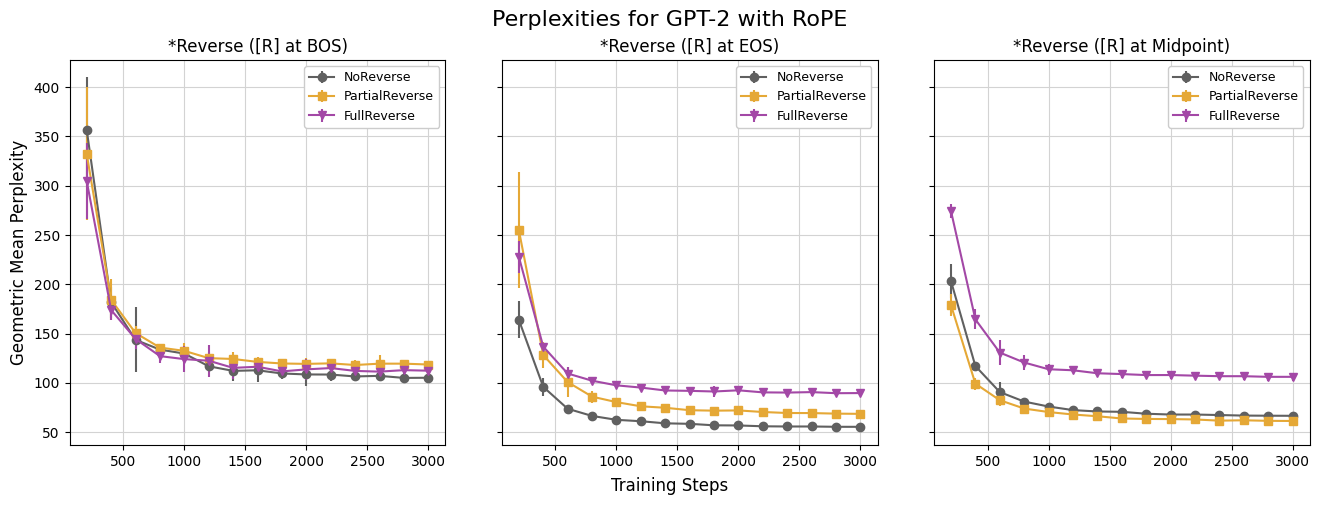

In [5]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))


reverse_file_info_eos = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_control", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_control", 'v', "-", 'FullReverse'),
]
reverse_file_info_bos = [
    ("reverse_control", "reverse_full", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_full", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
reverse_file_info_mid = [
    ("reverse_control", "reverse_partial", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_partial", 'v', "-", 'FullReverse'),
]

# Plot
plot_perplexities_grouped([reverse_file_info_bos, reverse_file_info_eos, reverse_file_info_mid],
                          ["*Reverse ([R] at BOS)", "*Reverse ([R] at EOS)", "*Reverse ([R] at Midpoint)"],
                          "gpt2", CHECKPOINTS)
plot_perplexities_grouped([reverse_file_info_bos, reverse_file_info_eos, reverse_file_info_mid],
                          ["*Reverse ([R] at BOS)", "*Reverse ([R] at EOS)", "*Reverse ([R] at Midpoint)"],
                          "alibi", CHECKPOINTS)
plot_perplexities_grouped([reverse_file_info_bos, reverse_file_info_eos, reverse_file_info_mid],
                          ["*Reverse ([R] at BOS)", "*Reverse ([R] at EOS)", "*Reverse ([R] at Midpoint)"],
                          "rope", CHECKPOINTS)
# plt.savefig("figures/perplexities.pdf", format="pdf", bbox_inches="tight")